In [104]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

In [84]:
df = pd.read_csv(r'D:\data sets\retail_sales_dataset.csv')

Data Preprocessing

In [85]:
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


In [87]:
print(df.isnull().sum())

Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64


In [88]:
print(f"Duplicates: {df.duplicated().sum()}")

Duplicates: 0


In [89]:
#Formating data
df['Date'] = pd.to_datetime(df['Date'])
df['Gender'] = df['Gender'].astype('category')
df['Product Category'] = df['Product Category'].astype('category')

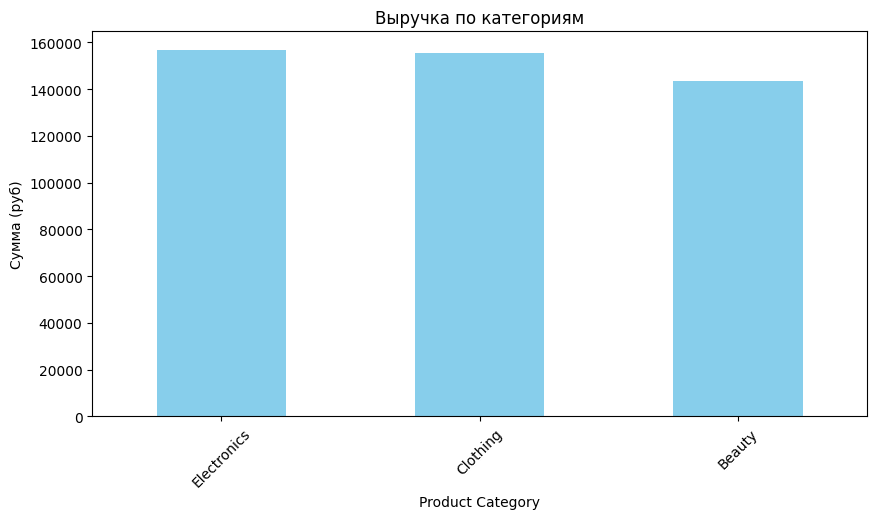

In [90]:
# 2. Топ категорий по выручке
category_revenue = df.groupby('Product Category', observed=True)['Total Amount'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
category_revenue.plot(kind='bar', color='skyblue')
plt.title('Выручка по категориям')
plt.ylabel('Сумма (руб)')
plt.xticks(rotation=45)
plt.show()

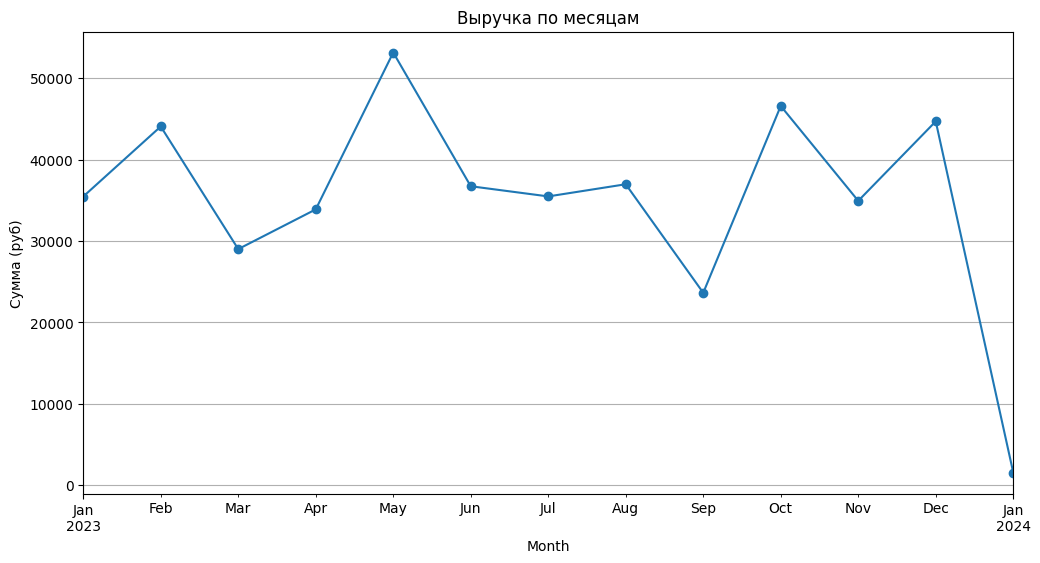

In [91]:
df['Month'] = df['Date'].dt.to_period('M')
monthly_revenue = df.groupby('Month', observed=True)['Total Amount'].sum()

plt.figure(figsize=(12, 6))
monthly_revenue.plot(kind='line', marker='o')
plt.title('Выручка по месяцам')
plt.ylabel('Сумма (руб)')
plt.grid()
plt.show()

Сustomer analysis

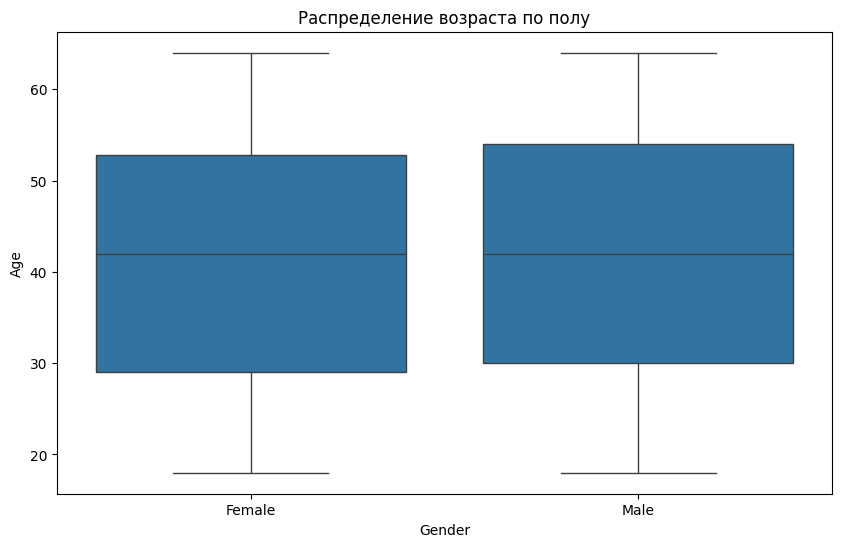

Gender
Female    456.549020
Male      455.428571
Name: Total Amount, dtype: float64


In [92]:
# 1. Распределение по полу и возрасту
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Gender', y='Age')
plt.title('Распределение возраста по полу')
plt.show()

# 2. Средний чек по полу
avg_bill_gender = df.groupby('Gender', observed=True)['Total Amount'].mean()
print(avg_bill_gender)

In [93]:
bins = [0, 18, 25, 35, 45, 60, 100]
labels = ['<18', '18-24', '25-34', '35-44', '45-60', '60+']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels)

# Анализ по полу и возрасту
age_gender_analysis = df.groupby(['Gender', 'Age_Group'], observed=True).agg(
    Total_Revenue=('Total Amount', 'sum'),
    Avg_Transaction=('Total Amount', 'mean'),
    Count=('Customer ID', 'nunique')
).reset_index()

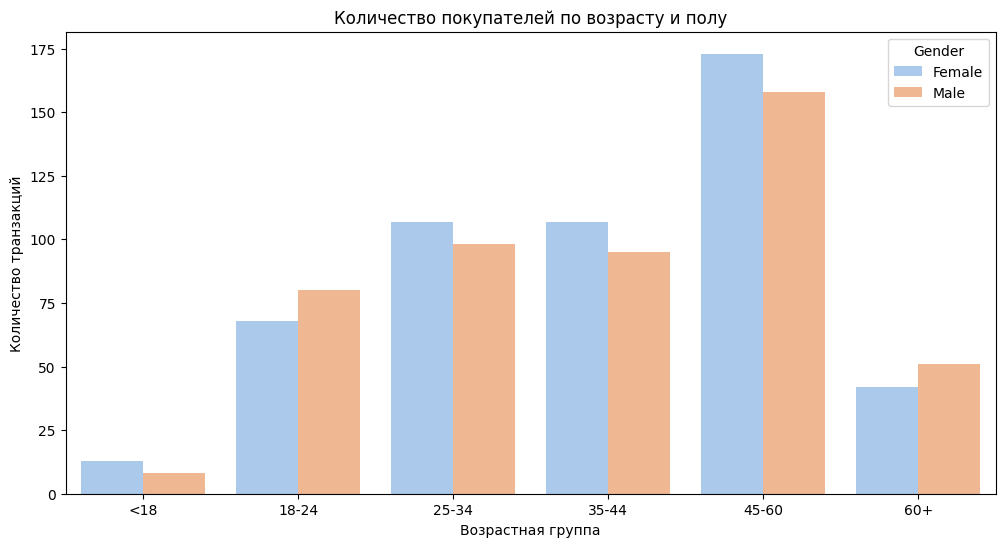

In [94]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Age_Group', hue='Gender', palette='pastel')
plt.title('Количество покупателей по возрасту и полу')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество транзакций')
plt.show()

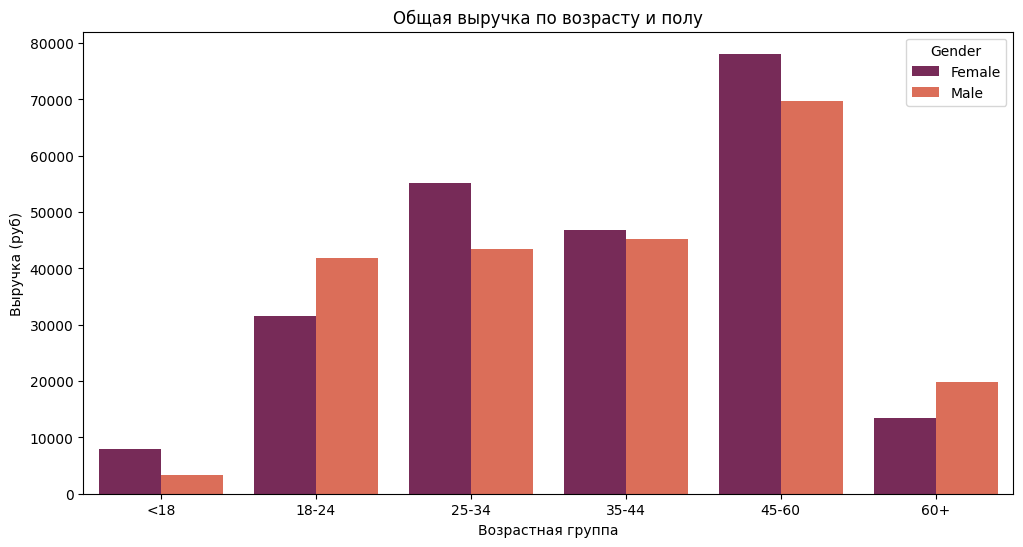

In [95]:
plt.figure(figsize=(12, 6))
sns.barplot(data=age_gender_analysis, x='Age_Group', y='Total_Revenue', hue='Gender', palette='rocket')
plt.title('Общая выручка по возрасту и полу')
plt.xlabel('Возрастная группа')
plt.ylabel('Выручка (руб)')
plt.show()

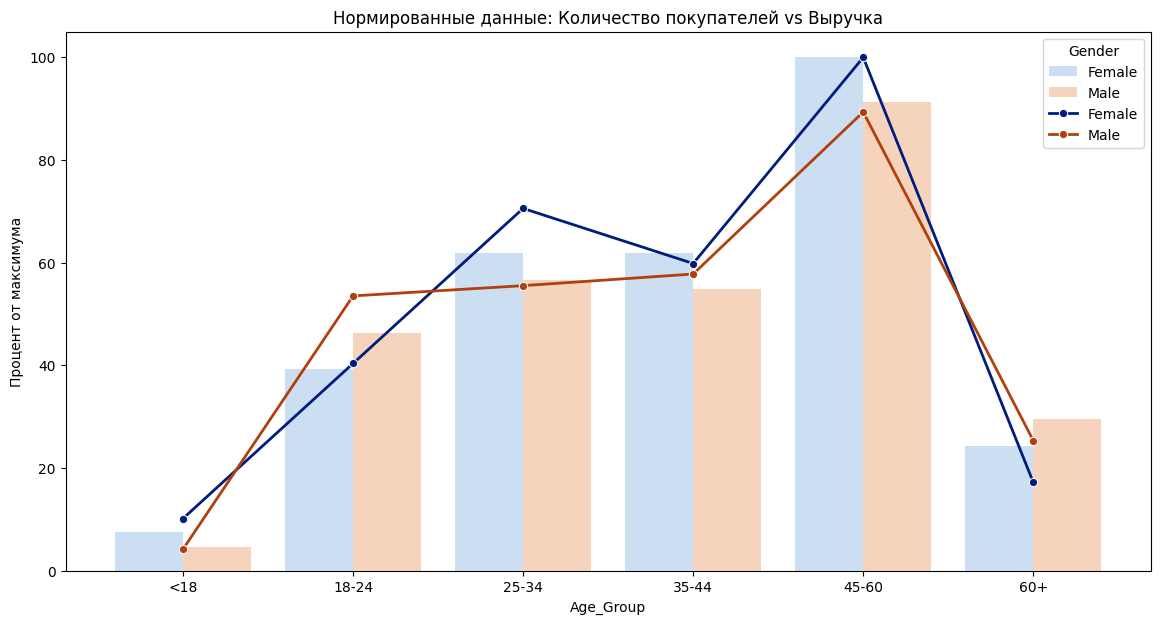

In [96]:
age_gender_analysis['Count_norm'] = (age_gender_analysis['Count'] / age_gender_analysis['Count'].max()) * 100
age_gender_analysis['Revenue_norm'] = (age_gender_analysis['Total_Revenue'] / age_gender_analysis['Total_Revenue'].max()) * 100

# График с нормированными осями
plt.figure(figsize=(14, 7))
sns.barplot(data=age_gender_analysis, x='Age_Group', y='Count_norm', hue='Gender', palette='pastel', alpha=0.6)
sns.lineplot(data=age_gender_analysis, x='Age_Group', y='Revenue_norm', hue='Gender', palette='dark', marker='o', linewidth=2)
plt.title('Нормированные данные: Количество покупателей vs Выручка')
plt.ylabel('Процент от максимума')
plt.show()

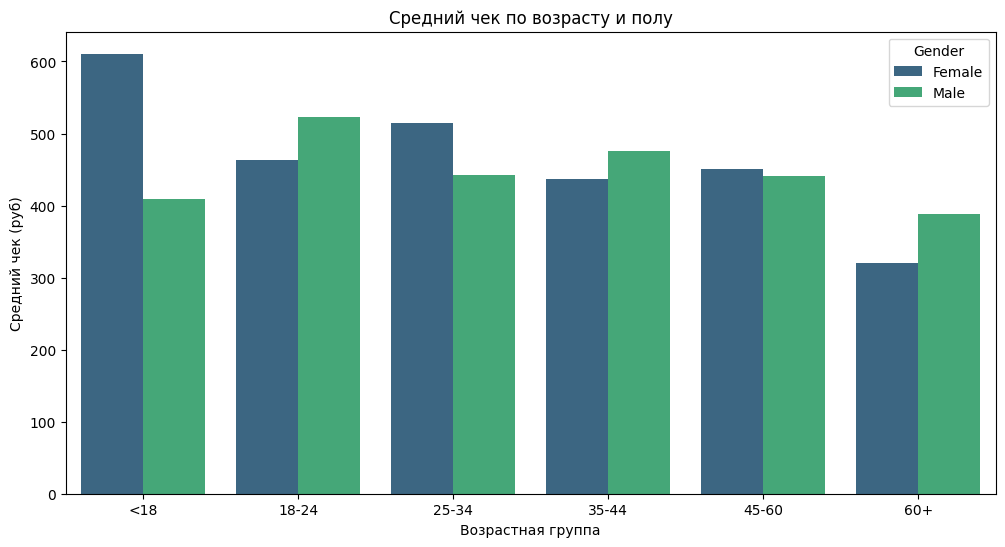

In [97]:
plt.figure(figsize=(12, 6))
sns.barplot(data=age_gender_analysis, x='Age_Group', y='Avg_Transaction', hue='Gender', palette='viridis')
plt.title('Средний чек по возрасту и полу')
plt.xlabel('Возрастная группа')
plt.ylabel('Средний чек (руб)')
plt.show()


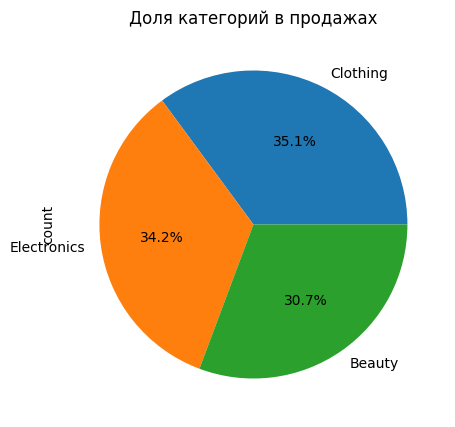

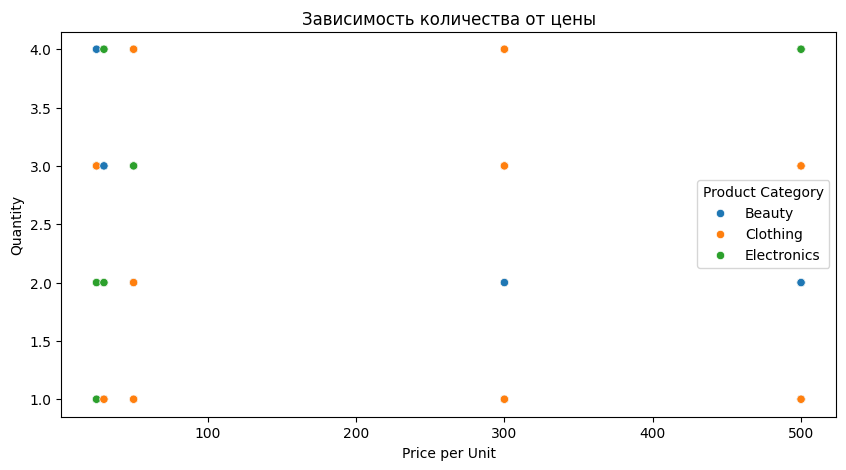

In [98]:
# 1. Топ товаров по количеству продаж
top_products = df['Product Category'].value_counts().head(3)
plt.figure(figsize=(10, 5))
top_products.plot(kind='pie', autopct='%1.1f%%')
plt.title('Доля категорий в продажах')
plt.show()

# 2. Соотношение цены и количества
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Price per Unit', y='Quantity', hue='Product Category')
plt.title('Зависимость количества от цены')
plt.show()

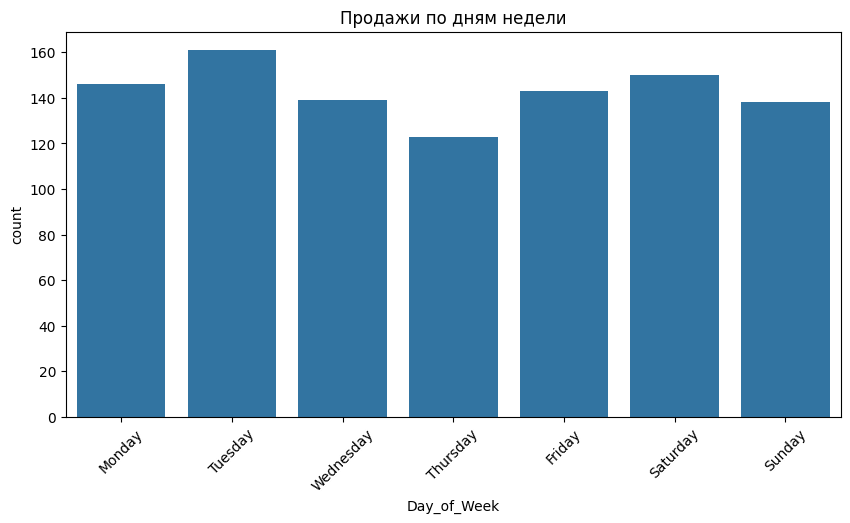

In [102]:
df['Day_of_Week'] = df['Date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day_of_Week'] = pd.Categorical(df['Day_of_Week'], categories=day_order, ordered=True)

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Day_of_Week')
plt.title('Продажи по дням недели')
plt.xticks(rotation=45)
plt.show()

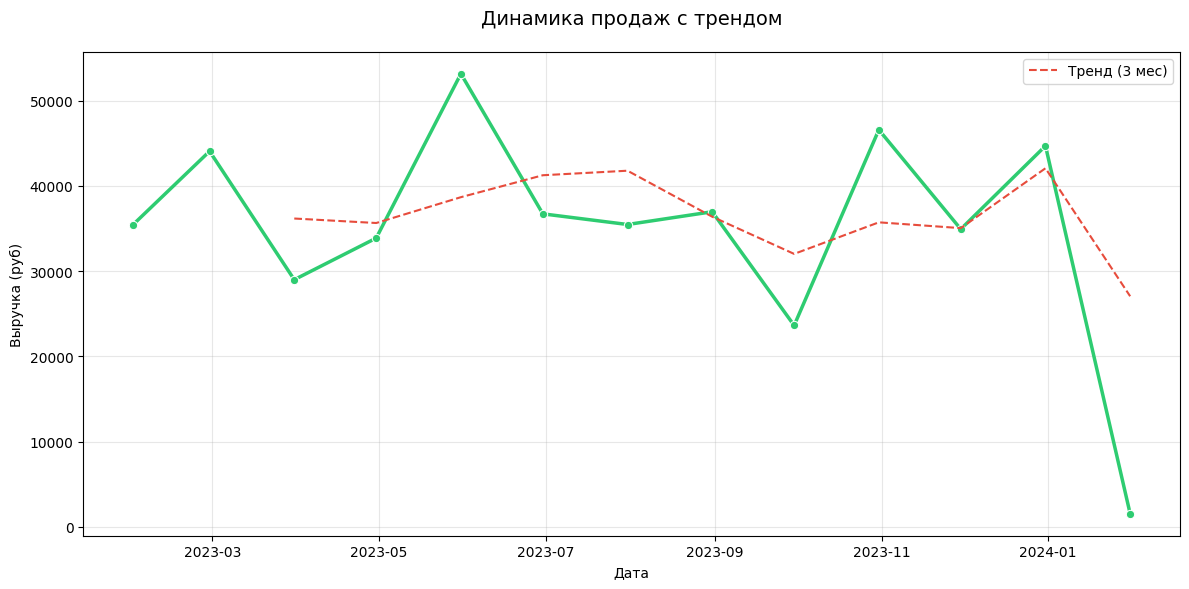

In [106]:
monthly_sales = df.groupby(pd.Grouper(key='Date', freq='ME'))['Total Amount'].sum().reset_index()

# Визуализация
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Date', y='Total Amount', 
             linewidth=2.5, color='#2ecc71', marker='o')

# Добавляем скользящее среднее
monthly_sales['MA_3'] = monthly_sales['Total Amount'].rolling(window=3).mean()
sns.lineplot(data=monthly_sales, x='Date', y='MA_3', 
             linestyle='--', color='#e74c3c', label='Тренд (3 мес)')

# Оформление
plt.title('Динамика продаж с трендом', pad=20, fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Выручка (руб)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [120]:
clv = df.groupby('Customer ID').agg({
    'Total Amount': 'sum',
    'Date': ['min', 'max'] 
}).reset_index()

clv.columns = ['Customer ID', 'Total_Spent', 'First_Purchase', 'Last_Purchase']
clv['CLV'] = clv['Total_Spent'] / ((clv['Last_Purchase'] - clv['First_Purchase']).dt.days + 1) * 30  # Нормируем на месяц

# Топ-5 клиентов
top_clv = clv.sort_values('CLV', ascending=False)
top_clv

,Customer ID,Total_Spent,First_Purchase,Last_Purchase,CLV
14,CUST015,2000,2023-01-16,2023-01-16,60000.0
412,CUST412,2000,2023-09-16,2023-09-16,60000.0
970,CUST970,2000,2023-05-16,2023-05-16,60000.0
547,CUST547,2000,2023-03-07,2023-03-07,60000.0
281,CUST281,2000,2023-05-23,2023-05-23,60000.0
...,...,...,...,...,...
379,CUST379,25,2023-02-05,2023-02-05,750.0
952,CUST952,25,2023-11-13,2023-11-13,750.0
371,CUST371,25,2023-02-21,2023-02-21,750.0
397,CUST397,25,2023-03-10,2023-03-10,750.0


,Customer ID,Total_Spent,First_Purchase,Last_Purchase,CLV
14,CUST015,2000,2023-01-16,2023-01-16,60000.0
412,CUST412,2000,2023-09-16,2023-09-16,60000.0
970,CUST970,2000,2023-05-16,2023-05-16,60000.0
547,CUST547,2000,2023-03-07,2023-03-07,60000.0
281,CUST281,2000,2023-05-23,2023-05-23,60000.0
...,...,...,...,...,...
379,CUST379,25,2023-02-05,2023-02-05,750.0
952,CUST952,25,2023-11-13,2023-11-13,750.0
371,CUST371,25,2023-02-21,2023-02-21,750.0
397,CUST397,25,2023-03-10,2023-03-10,750.0
